# 뉴스 요약봇 만들기 

### 목차 
1. 데이터 수집하기
2. 데이터 전처리하기 (추상적 요약)
3. 어텐션 메커니즘 사용하기 (추상적 요약)
4. 실제 결과와 요약문 비교하기 (추상적 요약)
5. Summa을 이용해서 추출적 요약해보기
------------------------------------------------------------------------------------------------------

**루브릭 평가 기준**


|<center>평가문항</center>|<center>상세기준</center>|
|:------|:------|
|1. Abstractive 모델 구성을 위한 텍스트 전처리 단계가 체계적으로 진행되었다.|분석단계, 정제단계, 정규화와 불용어 제거, 데이터셋 분리, 인코딩 과정이 빠짐없이 체계적으로 진행되었다.|
|2. 텍스트 요약모델이 성공적으로 학습되었음을 확인하였다.|모델학습이 안정적으로 수렴되었음을 그래프를 통해 확인하였으며, 실제 요약문과 유사한 요약문장을 얻을 수 있었다.|
|3. Extractive 요약을 시도해 보고 Abstractive 요약 결과과 함께 비교해 보았다.|두 요약 결과를 문법완성도 측면과 핵심단어 포함 측면으로 나누어 비교분석 결과를 제시하였다.|

-------------------------------------------------------------------------------------------------------------

## 텍스트 요약(Text Summarization)이란?
- 긴 길이의 문서(Document) 원문을 핵심 주제만으로 구성된 짧은 요약(Summary) 문장들로 변환하는 것
- 뉴스 기사로 작은 텍스트인 뉴스 제목을 만들어내는 것이 텍스트 요약의 대표적인 예

**1. 추출적 요약(Extractive Summarization)**
- 원문에서 문장들을 추출해서 요약하는 방식
- 원문을 구성하는 문장 중 어느 것이 요약문에 들어갈 핵심문장인지를 판별한다는 점에서 문장 분류(Text Classification) 문제로 볼 수 있음
- 딥 러닝보다는 주로 전통적인 머신 러닝 방식에 속하는 텍스트 랭크(TextRank)와 같은 알고리즘을 사용해서 이 방법을 사용
- 네이버 뉴스 서비스에 있는 요약봇 기능
- 어색하거나 문법적으로 이상한 결과물을 만드는 문제가 있음

**2. 추상적 요약(Abstractive Summarization)**
- 원문으로부터 내용이 요약된 새로운 문장을 생성해내는 것
- 자연어 처리 분야 중 자연어 생성(Natural Language Generation, NLG)의 영역

In [1]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')


[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 1. 데이터 수집하기

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98401


In [3]:
data.sample(10)

,headlines,text
94084,Chinese official demoted for not smoking near ...,China has demoted Communist party official Jel...
24579,Google partners second blockchain firm within ...,Google has partnered US-based blockchain start...
45658,"Music streaming service Spotify files for IPO,...",Music streaming service Spotify has announced ...
92722,Muralitharan 1st Sri Lankan to be inducted int...,Sri Lankan spin legend Muttiah Muralitharan wi...
38912,15 arrested for lynching 2 men in Assam over f...,Assam Police has arrested 15 people for being ...
74244,Olympic medal winning weightlifter Cholakov di...,"Bulgarian weightlifter Velichko Cholakov, an O..."
62002,Mumbai's 1st AC local train to have 'Aamchi Mu...,The exteriors of Mumbai's first fully air-cond...
43531,Former Zimbabwe President terms his forced exi...,Former Zimbabwean President Robert Mugabe has ...
48745,I made dumb joke: Canada PM for terming mankin...,Canadian PM Justin Trudeau has said that he ma...
71786,UP Man shoots 8-year-old after he refuses to g...,A 25-year-old man from Uttar Pradesh allegedly...


headlines와 text 두 열로 구성되어 있음 

# 2. 데이터 전처리하기 (추상적 요약)

In [4]:
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


중복된 샘플 제거하기(데이터 자체를 완전 바꿈)

In [5]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


null data 있는지 확인해보니 null값은 하나도 없는 것을 확인 

In [6]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


In [7]:
# 위의 데이터에는 null값이 없으므로 dropna를 할 필요 없음 
# data.dropna(axis=0, inplace=True)
# print('전체 샘플수 :', (len(data)))

### 텍스트 정규화
- 기계 학습 전에 미리 같은 표현으로 통일시켜주는 것이 기계의 연산량을 줄일 수 있는 방법
- 통일 시키지 않으면 다른 단어로 간주해서 연산량이 늘어남 

In [8]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


### 불용어(stopwords) 제거 
- 텍스트에는 자주 등장하지만 자연어 처리를 할 때 실질적으로 별 도움이 되지 않는 단어들
- NLTK에서 제공하는 불용어 리스트를 참조 nltk.download('stopwords') 위에서 실행 

In [9]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

Abstractive한 문장 요약 결과문이 자연스러운 문장이 되려면 이 불용어들이 headlines에는 남아 있는 게 더 좋을 것 같아서 불용어 미제거 

In [10]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens


전처리 전후 결과 확인을 위해 새로운 문장 작성하고 preprocess_sentence 함수 호출해보기

In [11]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_headlines = "Great way to start (or finish) the day!!! We're so happy"

print("text: ", preprocess_sentence(temp_text))
print("headlines :", preprocess_sentence(temp_headlines, False))  # 불용어를 제거하지 않습니다.

text:  everything bought great infact ordered twice third ordered wasfor mother father
headlines : great way to start the day we are so happy


전체 소문자로 변환, (), html 태그, 특수문자 제거, 텍스트 정규화가 잘 된 것을 볼 수 있다

실제 data에 함수 적용해보기 

In [12]:
temp_text_data = data['text'][5:10]
temp_headlines_data = data['headlines'][5:10]

print(temp_text_data)
print(temp_headlines_data)

5    Pakistani singer Rahat Fateh Ali Khan has deni...
6    India recorded their lowest ODI total in New Z...
7    Weeks after ex-CBI Director Alok Verma told th...
8    Andhra Pradesh CM N Chandrababu Naidu has said...
9    Congress candidate Shafia Zubair won the Ramga...
Name: text, dtype: object
5    Rahat Fateh Ali Khan denies getting notice for...
6    India get all out for 92, their lowest ODI tot...
7    Govt directs Alok Verma to join work 1 day bef...
8    Called PM Modi 'sir' 10 times to satisfy his e...
9    Cong wins Ramgarh bypoll in Rajasthan, takes t...
Name: headlines, dtype: object


In [13]:
print('temp_text_data :', preprocess_sentence(temp_text_data))
print('temp_headlines_data :', preprocess_sentence(temp_headlines_data, False))

AttributeError: 'Series' object has no attribute 'lower'

Serise에는 lower가 적용되지 않으므로 그냥 하나만 봐야겠다 

In [14]:
temp_text_data = data['text'][5]
temp_headlines_data = data['headlines'][5]

print('temp_text_data :', preprocess_sentence(temp_text_data), '\n')
print('temp_headlines_data :', preprocess_sentence(temp_headlines_data, False))

temp_text_data : pakistani singer rahat fateh ali khan denied receiving notice enforcement directorate allegedly smuggling foreign currency india would better authorities would served notice first publicised reads press release issued behalf rahat statement called allegation bizarre 

temp_headlines_data : rahat fateh ali khan denies getting notice for smuggling currency


### preprocess_sentence 함수를 사용해서 text와 headlines 전처리하기 

In [15]:
clean_text = []
# 전체 text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("text 전처리 후 결과: ", clean_text[:5])

text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [16]:
clean_headlines = []
# 전체 headlines 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))

print("headlines 전처리 후 결과: ", clean_headlines[:5])

headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


In [17]:
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)
print('check')

check


In [18]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [19]:
# null값 없음 
# data.dropna(axis=0, inplace=True)
# print('전체 샘플수 :', (len(data)))

텍스트와 요약 길이 확인

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


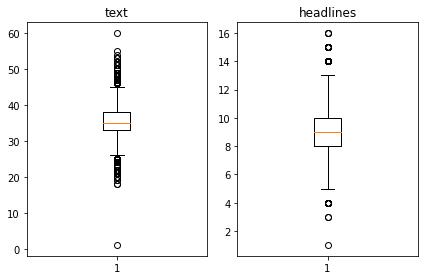

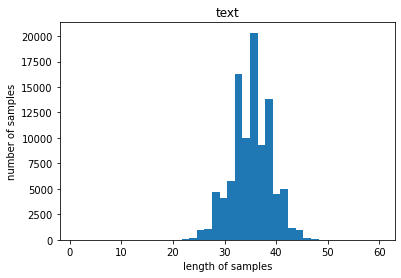

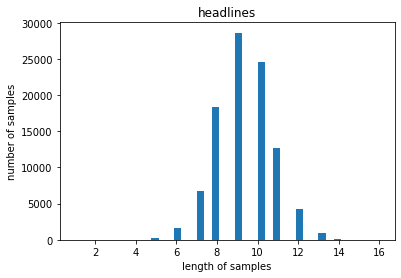

In [20]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

- 텍스트의 최대길이는 60, 요약의 최대 길이는 16인 것을 알 수 있다. 
- 텍스트 최대 길이를 40, 요약의 최대 길이를 11로 임의로 정해봄 

In [21]:
text_max_len = 38
summary_max_len = 11

- 얼마나 많은 샘플들을 자르지 않고 포함할 수 있는지 통계로 확인하는 편이 객관적으로 길이를 결정하는 데 도움이 됨 
- 훈련 데이터와 샘플의 길이를 입력하면, 데이터의 몇 %가 해당하는지 계산하는 함수를 만들어서 좀 더 정확하게 판단해보기 

In [22]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))
print('check')

check


In [23]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(summary_max_len,  data['headlines'])

전체 샘플 중 길이가 38 이하인 샘플의 비율: 0.8163379422529483
전체 샘플 중 길이가 11 이하인 샘플의 비율: 0.9449877999186661


- 위와 같이 하면 해당 길이보다 긴 샘플들은 잘리게 된다. 나름 비율은 괜찮은데 샘플을 그냥 자르면 완전한 문장이 되지 않으므로 정해진 길이보다 길면 제외하는 방법으로 데이터를 정제
- 98360에서 75754로 샘플 수가 줄어듬 

In [24]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플 수 :', (len(data)))

전체 샘플 수 : 75754


### 시작 토큰과 종료 토큰 추가하기
- 디코더는 시작 토큰을 입력받아 문장을 생성하기 시작하고, 종료 토큰을 예측한 순간에 문장 생성을 멈춤
- seq2seq 훈련을 위해서는 디코더의 입력과 레이블에 시작 토큰과 종료 토큰을 추가할 필요가 있음
- 시작 토큰은 sostoken, 종료 토큰은 eostoken이라 임의로 명명
- 디코더의 입력에 해당하면서 시작 토큰이 맨 앞에 있는 문장의 이름을 decoder_input, 디코더의 출력 또는 레이블에 해당되면서 종료 토큰이 맨 뒤에 붙는 문장의 이름을 decoder_target

In [25]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
7,govt directs alok verma to join work day befor...,weeks ex cbi director alok verma told departme...,sostoken govt directs alok verma to join work ...,govt directs alok verma to join work day befor...
8,called pm modi sir times to satisfy his ego an...,andhra pradesh cm chandrababu naidu said met u...,sostoken called pm modi sir times to satisfy h...,called pm modi sir times to satisfy his ego an...


인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장

In [26]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블
print('check')

check


## train과 test 직접 코딩해서 나누기
encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스를 만들기

In [27]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[73753 49867 15446 ... 47036 50834 72911]


이 정수 시퀀스를 이용해 다시 데이터의 샘플 순서를 정의해 주면 잘 섞인 샘플이 됨

In [28]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]
print('check')

check


섞인 데이터를 8:2의 비율로 훈련 데이터와 테스트 데이터로 분리

In [29]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 15150


이렇게 정의한 테스트 데이터의 개수를 이용해 전체 데이터를 양분

In [30]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 60604
훈련 레이블의 개수 : 60604
테스트 데이터의 개수 : 15150
테스트 레이블의 개수 : 15150


## 단어 집합(vocabulary) 만들기 및 정수 인코딩
- 기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터의 단어들을 모두 정수로 바꿔야 함
-  각 단어에 고유한 정수를 맵핑하는 작업이 필요한데 이 과정을 단어 집합(vocabulary)을 만든다고 표현
- Keras의 토크나이저를 사용하면, 입력된 훈련 데이터로부터 단어 집합을 만들 수 있

In [31]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성
print('=3')

=3


- 빈도수가 낮은 단어들은 훈련 데이터에서 제외하고 진행
- 빈도수가 7회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인
- src_tokenizer.word_counts.items()에는 단어와 각 단어의 등장 빈도수가 저장되어 있음

In [32]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 60278
등장 빈도가 6번 이하인 희귀 단어의 수: 41246
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 19032
단어 집합에서 희귀 단어의 비율: 68.42629151597598
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.10150982452075


- 전체 등장 빈도에서 희귀 단어 등장 빈도 비율이 4% 밖에 되지 않는 것을 볼 수 있다. 
- 등장 빈도가 6회 이하인 단어들은 정수 인코딩 과정에서 빼고, 훈련 데이터에서 제거
- 단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 19032 이므로 단어 크기를 19000으로 제한

In [33]:
src_vocab = 19000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 19000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성
print('check')

check


- texts_to_sequences()는 생성된 단어 집합에 기반하여 입력으로 주어진 텍스트 데이터의 단어들을 모두 정수로 변환하는 정수 인코딩을 수행
-  이제 텍스트가 아닌 정수로 표현되는 것을 볼 수 있음 

In [34]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[1085, 570, 15, 1885, 1467, 64, 1, 2147, 258, 185, 853, 2558, 885, 1328, 551, 10188, 8040, 1467, 1, 252, 661, 636, 142, 560, 2572, 914, 2558, 885], [1232, 622, 1063, 12447, 186, 22, 1816, 6900, 403, 16618, 457, 8953, 27, 3077, 49, 1232, 3221, 622, 93, 8953, 928, 185, 187, 939, 289, 6691, 1514, 2], [205, 1978, 4160, 823, 2065, 355, 615, 276, 769, 2277, 5028, 11190, 1189, 2065, 615, 1874, 2398, 2355, 2035, 1823, 2277, 5028, 9906, 16619, 1867, 641, 205, 55, 3895, 28, 1400, 2277, 130]]


headlines 데이터도 동일한 작업 수행 

In [35]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)
print('check')

check


In [36]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 27031
등장 빈도가 5번 이하인 희귀 단어의 수: 17982
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9049
단어 집합에서 희귀 단어의 비율: 66.52362102770893
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.607281743995282


전체 등장 빈도에서 희귀 단어 등장 빈도 비율은 5.6%, 희귀단어 제외하면 9067, 9000을 단어 집합의 크기로 제한

In [37]:
tar_vocab = 9000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 577, 119, 7, 392, 4, 15, 19, 11, 1654, 1655, 718], [1, 2054, 3379, 804, 869, 16, 415, 4514], [1, 97, 540, 3884, 2178, 7580, 17, 17, 725], [1, 4152, 8, 2226, 1797, 89, 144, 5720, 8226], [1, 18, 2343, 6, 494, 4010, 1904, 504, 6085]]
target
decoder  [[577, 119, 7, 392, 4, 15, 19, 11, 1654, 1655, 718, 2], [2054, 3379, 804, 869, 16, 415, 4514, 2], [97, 540, 3884, 2178, 7580, 17, 17, 725, 2], [4152, 8, 2226, 1797, 89, 144, 5720, 8226, 2], [18, 2343, 6, 494, 4010, 1904, 504, 6085, 2]]


- 빈도수가 낮은 단어만으로 구성되었던 샘플들은 이제 빈(empty) 샘플이 되었을 가능성이 있음
- 길이가 긴 text에는 문제가 안되겠지만 원래부터 길이가 짧았던 headline 요약문의 경우 빈 샘플이 생길 수 있음
- 요약문인 decoder_input에는 sostoken 또는 decoder_target에는 eostoken이 추가된 상태이고, 이 두 토큰은 모든 샘플에서 등장하므로 빈도수가 샘플 수와 동일하게 매우 높으므로 단어 집합 제한에도 삭제되지 않음
- **길이가 0이 된 요약문의 실제 길이는 1로 나옴**(길이 0이 된 decoder_input에는 sostoken, decoder_target에는 eostoken만 남아 있으므로)

In [38]:
# 요약문의 길이가 1인 경우의 인덱스를 각각 drop_train과 drop_test에 라는 변수에 저장
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 60604
훈련 레이블의 개수 : 60604
테스트 데이터의 개수 : 15150
테스트 레이블의 개수 : 15150


생각보다 삭제할 데이터의 개수가 없네? 희귀 단어 등장 빈도 비율이 4~5% 정도여서 크게 영향이 없었다

### 패딩하기 
서로 다른 길이의 샘플들을 병렬 처리하기 위해 같은 길이로 맞춰주는 패딩 작업 실시 

In [39]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')
print('check')

check


# 모델 설계하기
### Encoder 설계(함수형 API를 이용)
- hidden state는 LSTM에서 얼만큼의 수용력(capacity)를 가질지를 정하는 파라미터(LSTM의 용량의 크기나, LSTM에서의 뉴런의 개수)
- recurrent dropout은 dropout을 레이어가 아닌 time step마다 해주는 방식(time step의 입력을 랜덤으로 생략)
- dropout과 recurrent dropout을 모두 사용한 것을 Variational Dropout이라고도 함

In [40]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

위의 경고문은 recurrent dropout을 사용할 시 cuDNN을 사용할 수 없어서 recurrent dropout을 사용하지 않을 때보다 학습 시간이 오래 걸린다는 의미

## Decoder 설계
LSTM의 입력을 정의할 때, initial_state의 인자값으로 인코더의 **hidden state와 cell state의 값**을 넣어줘야 함

In [41]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

- headlines의 단어장인 tar_vocab의 수많은 선택지 중 하나의 단어를 선택하는 다중 클래스 분류 문제를 풀어야 함
- Dense의 인자로 tar_vocab을 주고, 활성화 함수로 소프트맥스 함수를 사용

In [42]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 38)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 38, 128)      2432000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 38, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

## seq2seq 모델은?
- 인코더에서 입력 시퀀스를 컨텍스트 벡터라는 하나의 고정된 크기의 벡터 표현으로 압축하고, 디코더는 이 컨텍스트 벡터를 통해서 출력 시퀀스를 만들어 냄 

- RNN에 기반한 seq2seq 모델에는 크게 두 가지 문제
1. 하나의 고정된 크기의 벡터에 모든 정보를 압축하려고 하니까 정보 손실이 발생
2. RNN의 고질적인 문제인 기울기 소실(vanishing gradient) 문제가 존재

# 3. 어텐션 메커니즘이란?
- 디코더에서 출력 단어를 예측하는 매 시점(time step)마다, 인코더에서의 전체 입력 문장을 다시 한 번 참고한다는 점
- 전체 입력 문장을 전부 다 동일한 비율로 참고하는 것이 아니라, 해당 시점에서 **예측해야할 단어와 연관이 있는 입력 단어 부분을 좀 더 집중(attention)**해서 보게 됨 
- Attention(Q, K, V) = Attention Value
    - Q = Query : t 시점의 디코더 셀에서의 은닉 상태
    - K = Keys : 모든 시점의 인코더 셀의 은닉 상태들
    - V = Values : 모든 시점의 인코더 셀의 은닉 상태들

In [43]:
# TensorFlow에 이미 구현된 어텐션 함수(Bahdanau 스타일)를 가져옴
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 38)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 38, 128)      2432000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 38, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

위의 코드는 인코더의 hidden state들과 디코더의 hidden state들을 어텐션 함수의 입력으로 사용하고, 어텐션 함수가 리턴한 값을 예측 시에 디코더의 hidden state와 함께 활용하는 형태로 작동

# 모델 훈련하기 
- 1 epoch 당 학습 시간이 꽤 걸려서 batch_size 256(2분) -> 512(80s)로 올림
- 최대한 컴퓨터 능력치를 활용해본다. nvidia-smi를 확인해보니 아까보다 좀 더 열심히 일하고 있다 

In [44]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=512, callbacks=[es], epochs=50)

Epoch 1/50
119/119 [==============================] - 80s 593ms/step - loss: 6.1977 - val_loss: 5.7782
Epoch 2/50
119/119 [==============================] - 70s 586ms/step - loss: 5.6867 - val_loss: 5.5211
Epoch 3/50
119/119 [==============================] - 69s 584ms/step - loss: 5.4208 - val_loss: 5.2470
Epoch 4/50
119/119 [==============================] - 68s 575ms/step - loss: 5.1640 - val_loss: 5.0318
Epoch 5/50
119/119 [==============================] - 67s 563ms/step - loss: 4.9488 - val_loss: 4.9051
Epoch 6/50
119/119 [==============================] - 67s 564ms/step - loss: 4.7527 - val_loss: 4.7207
Epoch 7/50
119/119 [==============================] - 67s 565ms/step - loss: 4.5802 - val_loss: 4.6401
Epoch 8/50
119/119 [==============================] - 67s 565ms/step - loss: 4.4313 - val_loss: 4.5248
Epoch 9/50
119/119 [==============================] - 67s 563ms/step - loss: 4.2956 - val_loss: 4.4365
Epoch 10/50
119/119 [==============================] - 67s 561ms/step - l

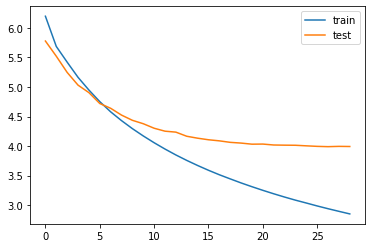

In [45]:
# loss, val_loss 값 시각화
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# 인퍼런스 모델 구현하기
- 테스트 단계에서는 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원해야 하므로, 필요한 3개의 사전을 아래와 같이 미리 준비

In [46]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

print('check')

check


- seq2seq는 훈련할 때와 실제 동작할 때(인퍼런스 단계)의 방식이 다르므로 그에 맞게 모델 설계를 별개로 진행해야 함
- 훈련 단계에서는 디코더의 입력부에 정답이 되는 문장 전체를 한꺼번에 넣고 디코더의 출력과 한 번에 비교할 수 있음 
- 정답 문장이 없는 인퍼런스 단계에서는 만들어야 할 문장의 길이만큼 디코더가 반복 구조로 동작해야 하기 때문에 부득이하게 인퍼런스를 위한 모델 설계를 별도로 분리해서 설계

In [47]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

print('=3')

=3


어텐션 메커니즘을 사용하는 출력층 설계

In [48]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

print('=3')

=3


인퍼런스 단계에서 단어 시퀀스를 완성하는 함수

In [49]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence
print('check')

check


# 4. 실제 결과와 요약문 비교하기 (추상적 요약)
## 모델 테스트 하기

### 정수 시퀀스를 텍스트 시퀀스로 변환하는 함수 만들기
- text의 정수 시퀀스에서는 패딩을 위해 사용되는 숫자 0을 제외
- headline의 정수 시퀀스에서는 숫자 0, 시작 토큰의 인덱스, 종료 토큰의 인덱스를 출력에서 제외

In [50]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

print('check')

check


테스트 데이터 약 50개의 샘플에 대해서 실제 요약과 예측된 요약을 비교

In [51]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print()

원문 : allahabad high court friday directed uttar pradesh government renew old licenses grant new ones slaughterhouses meat shops state several meat shop owners filed petition saying government licenses court also heard pils operation slaughterhouses 
실제 요약 : allahabad hc orders up govt to 
예측 요약 :  hc directs up to use of trees to

원문 : veteran singer lata mangeshkar said would love sing late actress sridevi producer boney kapoor daughter janhvi kapoor recently made acting debut dhadak year old singer added boney close family friend lost suddenly daughter debut reason smile 
실제 요약 : would love to sing for janhvi kapoor lata 
예측 요약 :  sridevi sridevi to play sridevi in sridevi

원문 : cristiano ronaldo failed score first match new club juventus side registered win rd minute goal season opening match saturday last time juventus conceded one goal opening match serie september 
실제 요약 : ronaldo goes goalless in his first match for juventus 
예측 요약 :  ronaldo scores goals in seconds to draw in



# 5. Summa을 이용해서 추출적 요약해보기

- Summa의 summarize()의 인자
1. text (str) : 요약할 테스트.
2. ratio (float, optional) – 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값
3. words (int or None, optional) – 출력에 포함할 단어 수.(만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시)
4. split (bool, optional) – True면 문장 list / False는 조인(join)된 문자열을 반환
--------------------------------------------------------------------------------------------------------

- Summa의 summarize는 문장 토큰화를 별도로 하지 않더라도 내부적으로 문장 토큰화를 수행하므로 원문을 바로 입력 가능 

In [52]:
# pip list | grep summa 설치하기 
import requests
from summa.summarizer import summarize

In [60]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
data

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...
...,...,...
98396,CRPF jawan axed to death by Maoists in Chhatti...,A CRPF jawan was on Tuesday axed to death with...
98397,First song from Sonakshi Sinha's 'Noor' titled...,"'Uff Yeh', the first song from the Sonakshi Si..."
98398,'The Matrix' film to get a reboot: Reports,"According to reports, a new version of the 199..."
98399,Snoop Dogg aims gun at clown dressed as Trump ...,A new music video shows rapper Snoop Dogg aimi...


In [62]:
data['text']

0        Saurav Kant, an alumnus of upGrad and IIIT-B's...
1        Kunal Shah's credit card bill payment platform...
2        New Zealand defeated India by 8 wickets in the...
3        With Aegon Life iTerm Insurance plan, customer...
4        Speaking about the sexual harassment allegatio...
                               ...                        
98396    A CRPF jawan was on Tuesday axed to death with...
98397    'Uff Yeh', the first song from the Sonakshi Si...
98398    According to reports, a new version of the 199...
98399    A new music video shows rapper Snoop Dogg aimi...
98400    Madhesi Morcha, an alliance of seven political...
Name: text, Length: 98401, dtype: object

In [63]:
for idx, (head, text) in enumerate(zip(data['headlines'], data['text'])):
    if idx == 30:
        break
    print("원문 :", text)
    print("실제 요약 :", head)
    print("예측 요약 :", summarize(text, ratio=0.35))
    print("\n")

원문 : Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
실제 요약 : upGrad learner switches to career in ML & Al with 90% salary hike
예측 요약 : upGrad's Online Power Learning has powered 3 lakh+ careers.


원문 : Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
실제 요약 : Delhi techie wins free food from Swiggy for one year on CRED
예측 요약 : Users get one CRED coin per rupee of bill pai

## 결론 

- seq2seq와 어텐션의 자체의 조합을 좀 더 좋게 수정하는 방법도 있고, 빔 서치(beam search), 사전 훈련된 워드 임베딩(pre-trained word embedding), 또는 인코더 - 디코더 자체의 구조를 새로이 변경한 하는 트랜스포머(Transformer)와 같은 여러 개선 방안들이 존재

- 추상적 요약과 추출적 요약을 했을 떄 추상적 요약이 좀 더 성능이 좋은 것 같다. lsm에서 알려준 위의 방법들을 적용해보면 더 좋은 성능을 가진 모델을 만들 수 있을 것이다.
- 추출적 요약의 결과를 보면 빈 값만 나타내는 경우도 있고, 예측된 요약을 보면 적절하지 않은 것을 볼 수 있다. 

## 회고 
1. 이번 프로젝트에서 어려웠던 점 
    - lms를 쭉 따라 해보아서 괜찮았다. 역시 자연어 처리라서 모델 훈련 시간이 좀 걸린다.
2. 프로젝트를 진행하면서 알아낸 점
    - 추상적 요약과 추출적 요약에 대해 알게 되었고 결과물의 차이점을 보면서 더 와닿았다.
    - 수완님이 알려주신 nvidia-smi를 통해 얼마나 컴퓨터를 잘 활용하는지 확인할 수 있었다.(batch_size 적절히 조절하기)
3. 자기 다짐 
    - 마음 잘 다잡고 화이팅


## 출처 
1. [정규화 사전](https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python)
2. [어텐션 메커니즘](https://wikidocs.net/22893)